In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD
from keras.utils import np_utils
from keras.utils import to_categorical
import matplotlib.cm as cm
from keras import optimizers
import keras
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import UpSampling2D
from keras.layers import Dropout
from keras.layers import BatchNormalization


Using TensorFlow backend.


In [2]:
# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

In [3]:
#Generate drawings function definition

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

In [4]:
#Rectangle generation

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


In [5]:
#Disk generation

def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

In [6]:
#Triangle generation

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]

In [7]:
def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]


In [8]:
def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

In [9]:
def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

In [10]:
def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

In [11]:
def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]


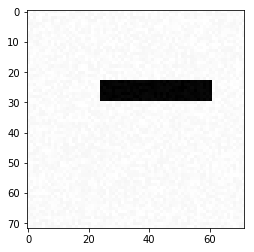

In [12]:
#Generate and plot a rectangle
im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

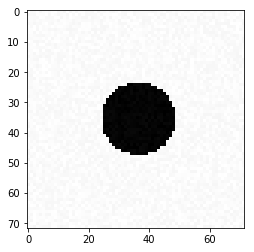

In [13]:
#Generate and plot a disk
im = generate_a_disk(10)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

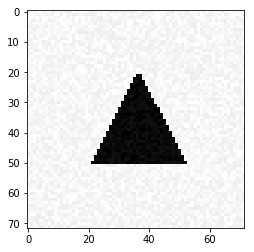

In [14]:
#Generate and plot a triangle
[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

# 3) Simple Classification


Let's first define our training set

In [15]:
[X_train, Y_train] = generate_dataset_classification(300, 20)

X_train.shape,Y_train.shape

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


((300, 5184), (300,))

In [16]:
Y_traink = keras.utils.to_categorical(Y_train, 3)
Y_traink.shape

(300, 3)

In [17]:
n_cols=X_train.shape[1]
n_cols

5184

### First : The Stochastic Gradient Descent Optimizer

In [22]:
model_SGDO=Sequential()

In [24]:
model_SGDO.add(Dense(units=32,kernel_initializer= 'uniform',input_dim=n_cols ,activation="relu"))
model_SGDO.add(Dropout(rate=0.2))
model_SGDO.add(Dense(units=10,kernel_initializer= 'uniform',activation="relu"))
model_SGDO.add(Dropout(rate=0.2))
model_SGDO.add(Dense(units=3,kernel_initializer= 'uniform',activation="softmax"))

In [25]:
sgd = SGD(lr=0.01,decay=1e-6, momentum=0.9,nesterov=True)
model_SGDO.compile(loss='mean_squared_error', optimizer=sgd, metrics=['accuracy'])

In [26]:
model_SGDO.fit(X_train, Y_traink, epochs=60, batch_size=32)

Epoch 1/60
300/300 [==============================] - 0s 771us/step - loss: 0.2223 - acc: 0.3067
Epoch 2/60
300/300 [==============================] - 0s 113us/step - loss: 0.2222 - acc: 0.3300
Epoch 3/60
300/300 [==============================] - 0s 110us/step - loss: 0.2222 - acc: 0.3300
Epoch 4/60
300/300 [==============================] - 0s 120us/step - loss: 0.2222 - acc: 0.3400
Epoch 5/60
300/300 [==============================] - 0s 116us/step - loss: 0.2222 - acc: 0.3433
Epoch 6/60
300/300 [==============================] - 0s 116us/step - loss: 0.2222 - acc: 0.3433
Epoch 7/60
300/300 [==============================] - 0s 116us/step - loss: 0.2221 - acc: 0.3433
Epoch 8/60
300/300 [==============================] - 0s 106us/step - loss: 0.2221 - acc: 0.3433
Epoch 9/60
300/300 [==============================] - 0s 106us/step - loss: 0.2221 - acc: 0.3567
Epoch 10/60
300/300 [==============================] - 0s 120us/step - loss: 0.2221 - acc: 0.3467
Epoch 11/60
300/300 [========

Let's evaluate our model : 

In [27]:
score_SGDO = model_SGDO.evaluate(X_train, Y_traink)
print(score_SGDO)

300/300 [==============================] - 0s 199us/step
[0.22126128693421682, 0.3466666668653488]


Now we're testing it on another figure, a disk

In [28]:
X_test = generate_a_disk()
# We need to reshape X_test
X_test = X_test.reshape(1, X_test.shape[0])
model_SGDO.predict(X_test)

array([[0.29132223, 0.66958886, 0.03908893]], dtype=float32)

In [29]:
### Second : The Adam Optimizer

In [30]:
model_Adam = Sequential()
model_Adam.add(Dense(3,kernel_initializer= 'uniform', activation='softmax',input_dim=n_cols))

model_Adam.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_Adam.fit(X_train, Y_traink,batch_size=32,epochs=25)

Epoch 1/25
300/300 [==============================] - 0s 489us/step - loss: 2.0314 - acc: 0.4367
Epoch 2/25
300/300 [==============================] - 0s 76us/step - loss: 1.2193 - acc: 0.4900
Epoch 3/25
300/300 [==============================] - 0s 76us/step - loss: 0.6575 - acc: 0.6633
Epoch 4/25
300/300 [==============================] - 0s 76us/step - loss: 0.6091 - acc: 0.7067
Epoch 5/25
300/300 [==============================] - 0s 76us/step - loss: 0.4219 - acc: 0.8067
Epoch 6/25
300/300 [==============================] - 0s 83us/step - loss: 0.3456 - acc: 0.8367
Epoch 7/25
300/300 [==============================] - 0s 86us/step - loss: 0.2664 - acc: 0.9467
Epoch 8/25
300/300 [==============================] - 0s 76us/step - loss: 0.2512 - acc: 0.9333
Epoch 9/25
300/300 [==============================] - 0s 83us/step - loss: 0.2178 - acc: 0.9633
Epoch 10/25
300/300 [==============================] - 0s 80us/step - loss: 0.1980 - acc: 0.9700
Epoch 11/25
300/300 [=================

Now we're testing it on another figure, a disk

In [31]:
X_test = generate_a_disk()
X_test = X_test.reshape(1, X_test.shape[0])
model_Adam.predict(X_test)

array([[0., 1., 0.]], dtype=float32)

## 4) Visualization of the solution


#### Visualization : Stochastic Gradient Descent Optimizer

In [32]:
Vizu_1=model_SGDO.get_weights()[0]

In [33]:
image1 = Vizu_1[:,0]
image2 = Vizu_1[:,1]
image3 = Vizu_1[:,2]

In [34]:
#getting the shapes of all 3 images
image1.shape,image2.shape,image3.shape

((5184,), (5184,), (5184,))

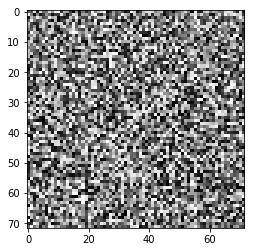

In [35]:
#Plotting the first image
%matplotlib inline 
plt.imshow(image1.reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')

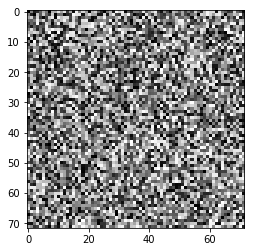

In [36]:
#Plotting the second image
%matplotlib inline 
plt.imshow(image2.reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')

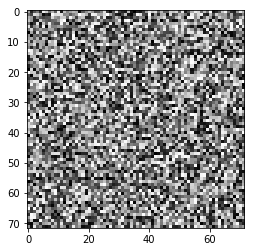

In [37]:
#Plotting the third image
plt.imshow(image3.reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')

#### Visualization : Adam Optimizer

In [39]:
Vizu_2=model_Adam.get_weights()[0]

In [41]:
image1 = Vizu_2[:,0]
image2 = Vizu_2[:,1]
image3 = Vizu_2[:,2]

In [42]:
#getting the shapes of all 3 images
image1.shape,image2.shape,image3.shape

((5184,), (5184,), (5184,))

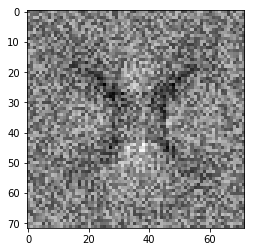

In [43]:
#Plotting the first image
%matplotlib inline 
plt.imshow(image1.reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')

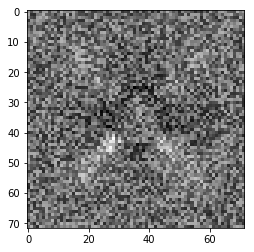

In [44]:
#Plotting the second image
%matplotlib inline 
plt.imshow(image2.reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')

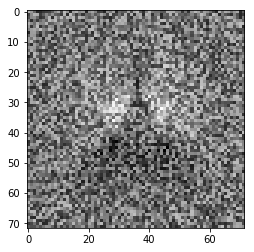

In [45]:
#Plotting the third image
plt.imshow(image3.reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')

## 5) A More Difficult Classification Problem

### Adam Model

We generate a Train and a Test Sets

In [46]:
[X_train2, Y_train2] = generate_dataset_classification(300, 20, True)
Y_train2k = keras.utils.to_categorical(Y_train2, 3)

[X_test2, Y_test2] = generate_test_set_classification()

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


Let's create a model with Adam Optimizer

In [47]:
model_Adam2= Sequential()
model_Adam2.add(Dense(16, input_dim=5184, activation='relu'))
model_Adam2.add(Dense(3))

In [48]:
sgd = SGD(lr=0.01,decay=1e-6, momentum=0.9,nesterov=True)
model_Adam2.compile(loss='mean_squared_error', optimizer=sgd, metrics=['accuracy'])

In [49]:
model_Adam2.fit(X_train2, Y_train2k,batch_size=16,epochs=150,verbose=False)

Let's evaluate our model on the test set

In [50]:
model_Adam2.evaluate(X_test2, Y_test2)

300/300 [==============================] - 0s 186us/step


[0.22230109830697378, 0.34000000009934106]

We reshape X_train2 to fit a convolutional model

In [51]:
X_train2 = X_train2.reshape(X_train2.shape[0],72,72,1)

### Convolutional Model

In [52]:
model_Convo = Sequential()
model_Convo.add(Conv2D(16,kernel_size=(5, 5), activation='relu',input_shape=(72, 72, 1)))
model_Convo.add(MaxPooling2D(pool_size=(2, 2))) 
model_Convo.add(Flatten())
model_Convo.add(Dense(100,activation='relu'))
model_Convo.add(Dense(3,activation='sigmoid'))

In [53]:
sgd = SGD(lr=0.01,decay=1e-6, momentum=0.9,nesterov=True)
model_Convo.compile(loss='mean_squared_error', optimizer=sgd, metrics=['accuracy'])

In [54]:
model_Convo.fit(X_train2,Y_train2k, batch_size=16, epochs=15)

Epoch 1/15
300/300 [==============================] - 1s 4ms/step - loss: 0.2387 - acc: 0.3300
Epoch 2/15
300/300 [==============================] - 1s 3ms/step - loss: 0.2178 - acc: 0.3933
Epoch 3/15
300/300 [==============================] - 1s 3ms/step - loss: 0.2104 - acc: 0.4667
Epoch 4/15
300/300 [==============================] - 1s 3ms/step - loss: 0.2023 - acc: 0.5267
Epoch 5/15
300/300 [==============================] - 1s 3ms/step - loss: 0.1920 - acc: 0.5400
Epoch 6/15
300/300 [==============================] - 1s 3ms/step - loss: 0.1868 - acc: 0.5267
Epoch 7/15
300/300 [==============================] - 1s 3ms/step - loss: 0.1801 - acc: 0.5300
Epoch 8/15
300/300 [==============================] - 1s 3ms/step - loss: 0.1754 - acc: 0.5867
Epoch 9/15
300/300 [==============================] - 1s 3ms/step - loss: 0.1611 - acc: 0.6033
Epoch 10/15
300/300 [==============================] - 1s 3ms/step - loss: 0.1519 - acc: 0.6667
Epoch 11/15
300/300 [============================

In [55]:
[X_test3, Y_test3] = generate_test_set_classification()

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [57]:
model_Convo.evaluate(X_train2,Y_train2k)

300/300 [==============================] - 0s 874us/step


[0.12232029934724171, 0.7699999992052714]

In [58]:
print('The loss is : {0}'.format(model_Convo.evaluate(X_test3.reshape(X_test3.shape[0],72,72,1),Y_test3)[0]))

300/300 [==============================] - 0s 745us/step
The loss is : 0.15714460452397663


# 6) A Regression Problem

####  We're going to try to predict the image locations of the vertices for a triangle

Let's create our data-train

In [63]:
[X_train, Y_train] = generate_dataset_regression(300, 20)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


NameError: name 'patches' is not defined

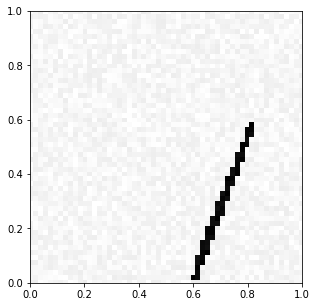

In [64]:
visualize_prediction(X_train[0], Y_train[0])
print(Y_train[0].reshape(3,2))

Let's create our data-validation

In [65]:
[X_validation, Y_validation] = generate_dataset_regression(300, 20)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [66]:
regressor = Sequential()

In [67]:
regressor.add(Dense(units=128,kernel_initializer= 'uniform',activation="relu", input_dim=n_cols))
regressor.add(Dropout(0.3))
regressor.add(Dense(units=128,kernel_initializer= 'uniform',activation="relu"))
regressor.add(Dropout(0.3))
regressor.add(Dense(units=6,kernel_initializer= 'uniform'))

In [69]:
regressor.compile(optimizer="adam", loss='mse', metrics= ["mse"])
history=regressor.fit(X_train,Y_train,validation_data=(X_validation,Y_validation),batch_size=32, epochs=300)

Train on 300 samples, validate on 300 samples
Epoch 1/300
300/300 [==============================] - 0s 2ms/step - loss: 0.1726 - mean_squared_error: 0.1726 - val_loss: 0.0865 - val_mean_squared_error: 0.0865
Epoch 2/300
300/300 [==============================] - 0s 482us/step - loss: 0.1061 - mean_squared_error: 0.1061 - val_loss: 0.1013 - val_mean_squared_error: 0.1013
Epoch 3/300
300/300 [==============================] - 0s 455us/step - loss: 0.0989 - mean_squared_error: 0.0989 - val_loss: 0.0852 - val_mean_squared_error: 0.0852
Epoch 4/300
300/300 [==============================] - 0s 465us/step - loss: 0.0935 - mean_squared_error: 0.0935 - val_loss: 0.0845 - val_mean_squared_error: 0.0845
Epoch 5/300
300/300 [==============================] - 0s 475us/step - loss: 0.0912 - mean_squared_error: 0.0912 - val_loss: 0.0812 - val_mean_squared_error: 0.0812
Epoch 6/300
300/300 [==============================] - 0s 475us/step - loss: 0.0931 - mean_squared_error: 0.0931 - val_loss: 0.0962

300/300 [==============================] - 0s 512us/step - loss: 0.0738 - mean_squared_error: 0.0738 - val_loss: 0.0807 - val_mean_squared_error: 0.0807
Epoch 51/300
300/300 [==============================] - 0s 532us/step - loss: 0.0724 - mean_squared_error: 0.0724 - val_loss: 0.0835 - val_mean_squared_error: 0.0835
Epoch 52/300
300/300 [==============================] - 0s 499us/step - loss: 0.0724 - mean_squared_error: 0.0724 - val_loss: 0.0749 - val_mean_squared_error: 0.0749
Epoch 53/300
300/300 [==============================] - 0s 512us/step - loss: 0.0721 - mean_squared_error: 0.0721 - val_loss: 0.0775 - val_mean_squared_error: 0.0775
Epoch 54/300
300/300 [==============================] - 0s 555us/step - loss: 0.0719 - mean_squared_error: 0.0719 - val_loss: 0.0823 - val_mean_squared_error: 0.0823
Epoch 55/300
300/300 [==============================] - 0s 532us/step - loss: 0.0714 - mean_squared_error: 0.0714 - val_loss: 0.0745 - val_mean_squared_error: 0.0745
Epoch 56/300
300/

300/300 [==============================] - 0s 479us/step - loss: 0.0692 - mean_squared_error: 0.0692 - val_loss: 0.0764 - val_mean_squared_error: 0.0764
Epoch 100/300
300/300 [==============================] - 0s 455us/step - loss: 0.0672 - mean_squared_error: 0.0672 - val_loss: 0.0782 - val_mean_squared_error: 0.0782
Epoch 101/300
300/300 [==============================] - 0s 465us/step - loss: 0.0683 - mean_squared_error: 0.0683 - val_loss: 0.0791 - val_mean_squared_error: 0.0791
Epoch 102/300
300/300 [==============================] - 0s 502us/step - loss: 0.0694 - mean_squared_error: 0.0694 - val_loss: 0.0731 - val_mean_squared_error: 0.0731
Epoch 103/300
300/300 [==============================] - 0s 459us/step - loss: 0.0707 - mean_squared_error: 0.0707 - val_loss: 0.0744 - val_mean_squared_error: 0.0744
Epoch 104/300
300/300 [==============================] - 0s 459us/step - loss: 0.0689 - mean_squared_error: 0.0689 - val_loss: 0.0818 - val_mean_squared_error: 0.0818
Epoch 105/30

300/300 [==============================] - 0s 532us/step - loss: 0.0663 - mean_squared_error: 0.0663 - val_loss: 0.0777 - val_mean_squared_error: 0.0777
Epoch 149/300
300/300 [==============================] - 0s 479us/step - loss: 0.0680 - mean_squared_error: 0.0680 - val_loss: 0.0746 - val_mean_squared_error: 0.0746
Epoch 150/300
300/300 [==============================] - 0s 475us/step - loss: 0.0683 - mean_squared_error: 0.0683 - val_loss: 0.0750 - val_mean_squared_error: 0.0750
Epoch 151/300
300/300 [==============================] - 0s 512us/step - loss: 0.0658 - mean_squared_error: 0.0658 - val_loss: 0.0731 - val_mean_squared_error: 0.0731
Epoch 152/300
300/300 [==============================] - 0s 532us/step - loss: 0.0671 - mean_squared_error: 0.0671 - val_loss: 0.0782 - val_mean_squared_error: 0.0782
Epoch 153/300
300/300 [==============================] - 0s 505us/step - loss: 0.0686 - mean_squared_error: 0.0686 - val_loss: 0.0780 - val_mean_squared_error: 0.0780
Epoch 154/30

300/300 [==============================] - 0s 485us/step - loss: 0.0653 - mean_squared_error: 0.0653 - val_loss: 0.0754 - val_mean_squared_error: 0.0754
Epoch 198/300
300/300 [==============================] - 0s 519us/step - loss: 0.0650 - mean_squared_error: 0.0650 - val_loss: 0.0758 - val_mean_squared_error: 0.0758
Epoch 199/300
300/300 [==============================] - 0s 462us/step - loss: 0.0660 - mean_squared_error: 0.0660 - val_loss: 0.0753 - val_mean_squared_error: 0.0753
Epoch 200/300
300/300 [==============================] - 0s 472us/step - loss: 0.0687 - mean_squared_error: 0.0687 - val_loss: 0.0767 - val_mean_squared_error: 0.0767
Epoch 201/300
300/300 [==============================] - 0s 479us/step - loss: 0.0689 - mean_squared_error: 0.0689 - val_loss: 0.0774 - val_mean_squared_error: 0.0774
Epoch 202/300
300/300 [==============================] - 0s 492us/step - loss: 0.0671 - mean_squared_error: 0.0671 - val_loss: 0.0783 - val_mean_squared_error: 0.0783
Epoch 203/30

300/300 [==============================] - 0s 465us/step - loss: 0.0654 - mean_squared_error: 0.0654 - val_loss: 0.0717 - val_mean_squared_error: 0.0717
Epoch 247/300
300/300 [==============================] - 0s 472us/step - loss: 0.0646 - mean_squared_error: 0.0646 - val_loss: 0.0757 - val_mean_squared_error: 0.0757
Epoch 248/300
300/300 [==============================] - 0s 472us/step - loss: 0.0650 - mean_squared_error: 0.0650 - val_loss: 0.0716 - val_mean_squared_error: 0.0716
Epoch 249/300
300/300 [==============================] - 0s 492us/step - loss: 0.0660 - mean_squared_error: 0.0660 - val_loss: 0.0738 - val_mean_squared_error: 0.0738
Epoch 250/300
300/300 [==============================] - 0s 499us/step - loss: 0.0668 - mean_squared_error: 0.0668 - val_loss: 0.0739 - val_mean_squared_error: 0.0739
Epoch 251/300
300/300 [==============================] - 0s 525us/step - loss: 0.0652 - mean_squared_error: 0.0652 - val_loss: 0.0708 - val_mean_squared_error: 0.0708
Epoch 252/30

300/300 [==============================] - 0s 462us/step - loss: 0.0646 - mean_squared_error: 0.0646 - val_loss: 0.0741 - val_mean_squared_error: 0.0741
Epoch 296/300
300/300 [==============================] - 0s 472us/step - loss: 0.0650 - mean_squared_error: 0.0650 - val_loss: 0.0771 - val_mean_squared_error: 0.0771
Epoch 297/300
300/300 [==============================] - 0s 422us/step - loss: 0.0632 - mean_squared_error: 0.0632 - val_loss: 0.0723 - val_mean_squared_error: 0.0723
Epoch 298/300
300/300 [==============================] - 0s 462us/step - loss: 0.0642 - mean_squared_error: 0.0642 - val_loss: 0.0772 - val_mean_squared_error: 0.0772
Epoch 299/300
300/300 [==============================] - 0s 429us/step - loss: 0.0641 - mean_squared_error: 0.0641 - val_loss: 0.0745 - val_mean_squared_error: 0.0745
Epoch 300/300
300/300 [==============================] - 0s 436us/step - loss: 0.0659 - mean_squared_error: 0.0659 - val_loss: 0.0704 - val_mean_squared_error: 0.0704


Let's vizualise the train-MSE and the validation-MSE

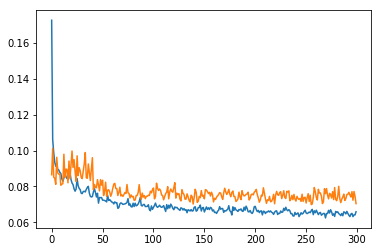

In [72]:
plt.plot(history.history["mean_squared_error"])
plt.plot(history.history["val_mean_squared_error"])

Let's create our data-test

In [73]:
[X_test, Y_test] = generate_test_set_regression()

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [74]:
Y_pred=regressor.predict(X_test)

NameError: name 'patches' is not defined

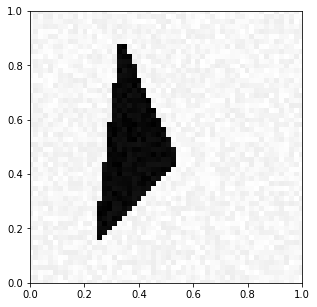

In [75]:
visualize_prediction(X_test[2], Y_test[2])
visualize_prediction(X_test[2], Y_pred[2])

In [82]:
X_train = X_train.reshape([-1, 72,72,1])
X_validation = X_validation.reshape([-1, 72,72,1])

In [83]:
CNN_regressor = Sequential()

In [84]:
CNN_regressor.add(Conv2D(256,(3,3),input_shape=(72,72,1,),padding="same", activation='relu'))
CNN_regressor.add(BatchNormalization())
CNN_regressor.add(MaxPooling2D(pool_size=(2,2)))

CNN_regressor.add(Conv2D(256,(3,3),input_shape=(72,72,1,), padding="same",activation='relu'))
CNN_regressor.add(BatchNormalization())
CNN_regressor.add(MaxPooling2D(pool_size=(2,2)))

CNN_regressor.add(Conv2D(256,(3,3),input_shape=(72,72,1,), padding="same",activation='relu'))
CNN_regressor.add(BatchNormalization())
CNN_regressor.add(MaxPooling2D(pool_size=(2,2)))


CNN_regressor.add(Flatten())
CNN_regressor.add(Dense(units=64, kernel_initializer="uniform", activation="relu"))
CNN_regressor.add(BatchNormalization())
CNN_regressor.add(Dense(units=6, kernel_initializer="uniform"))
CNN_regressor.compile(loss='mse', optimizer='adam', metrics= ["mse"])
#CNN_classifier.fit_generator((X_Train,Y_Train),steps_per_epoch=X_train.shape[0]/32, validation_data=(X_Val, Y_val),epochs=200, validation_steps=X_val.shape[0]/32,callbacks=[History])
history=CNN_regressor.fit(X_train,Y_train,batch_size=32, validation_data=(X_validation, Y_validation),epochs=20)

Train on 300 samples, validate on 300 samples
Epoch 1/20
160/300 [===============>..............] - ETA: 33s - loss: 0.3356 - mean_squared_error: 0.3356

KeyboardInterrupt: 

In [85]:
X_test = X_test.reshape([-1, 72,72,1])

In [86]:
Y_pred=CNN_regressor.predict(X_test)

NameError: name 'patches' is not defined

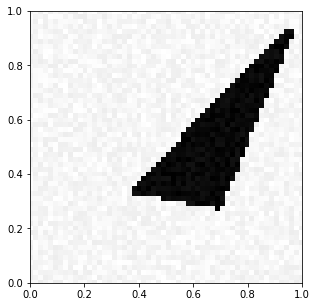

In [87]:
visualize_prediction(X_test[0], Y_test[0])
visualize_prediction(X_test[0], Y_pred[0])

# 7) Image Denoising 

Creating new functions we'll use on this exercise

In [ ]:
def generate_a_drawing2(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize, figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0, figsize)
    ax.set_ylim(0, figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[
        ::3].astype(np.float32)
    imdatan = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdatan, imdata

In [ ]:
def generate_a_triangle2(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random()) * figsize / 2
        middle = figsize / 2
        U = (middle, middle + size, middle - size)
        V = (middle + size, middle - size, middle - size)
    imdatan, imdata = generate_a_drawing2(figsize, U, V, noise)
    return [imdatan,imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]

In [ ]:
def generate_a_rectangle2(noise=0.0, free_location=False):
    figsize = 1.0
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize / 2 + side / 2
        bottom = figsize / 2 - side / 2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing2(figsize, U, V, noise)

In [ ]:
def generate_a_disk2(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize / 2, figsize / 2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize / 2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2 * np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing2(figsize, U, V, noise)

In [ ]:
def generate_dataset_2(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle2()[0].shape[0]
    X = np.zeros([nb_samples, im_size])
    Y = np.zeros([nb_samples, im_size])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 100 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i], Y[i] = generate_a_rectangle2(noise, free_location)
        elif category == 1:
            X[i],Y[i] = generate_a_disk2(noise, free_location)
        else:
            [X[i],Y[i], V] = generate_a_triangle2(noise, free_location)
    X = (X + noise) / (255 + 2 * noise)
    Y = Y/255
    return [X, Y]

In [ ]:
#Creating our training set
[X_train5,Y_train5]=generate_dataset_2(500,20,True)

In [ ]:
#Plotting the image based on the training set
plt.imshow(Y_train5[300].reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')

In [ ]:
plt.imshow(X_train5[300].reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')

In [ ]:
X_train_last = X_train5.reshape(X_train5.shape[0],72,72,1)
Y_train_last = Y_train5.reshape(Y_train5.shape[0],72,72,1)

In [ ]:
model_last = Sequential()

In [ ]:
# The Input Layer :
model_last.add(Conv2D(32,(3, 3), activation='relu',padding = 'same' ,input_shape=(72,72,1)))
model_last.add(MaxPooling2D(pool_size=(2, 2)))
model_last.add(Conv2D(32,(3,3), activation = 'relu', padding = 'same'))
model_last.add(MaxPooling2D(pool_size=(2,2)))

model_last.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding = 'same'))
model_last.add(UpSampling2D(size=(2, 2)))
model_last.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding = 'same'))
model_last.add(UpSampling2D(size=(2, 2)))
model_last.add(Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding = 'same'))

In [ ]:
model_last.compile(optimizer='adadelta',loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
model_last.fit(X_train_last, Y_train_last, epochs=10, batch_size=64)

In [ ]:
Ximage = X_train_last[9]
Ximage = Ximage.reshape(1,72,72,1)

In [ ]:
prediction=model_last.predict(Ximage)

In [ ]:
prediction=prediction.reshape(72,72)

In [ ]:
plt.imshow(prediction, cmap='gray')